In [268]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [269]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from tensorflow import keras
#import keras.api._v2.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical, load_img
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tqdm import tqdm
import random
import pickle
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.optimizers import SGD, Adam 


In [270]:
sm.set_framework('tf.keras')

In [271]:
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image=cv2.imread(folder_dir+'/'+images, 1)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (512, 512))
        image=np.array(image)
        image_dataset.append(image)
    return image_dataset

In [272]:
image_dataset=data_loader("E:/Offroad database/Rest of the files/data/Data_no_non_traversable_vegetation/Augmented/sample images")

In [273]:
mask_dataset=data_loader("E:/Offroad database/Rest of the files/data/Data_no_non_traversable_vegetation/Augmented/sample labels")

In [274]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

In [275]:
mask_dataset.shape

(1414, 512, 512, 3)

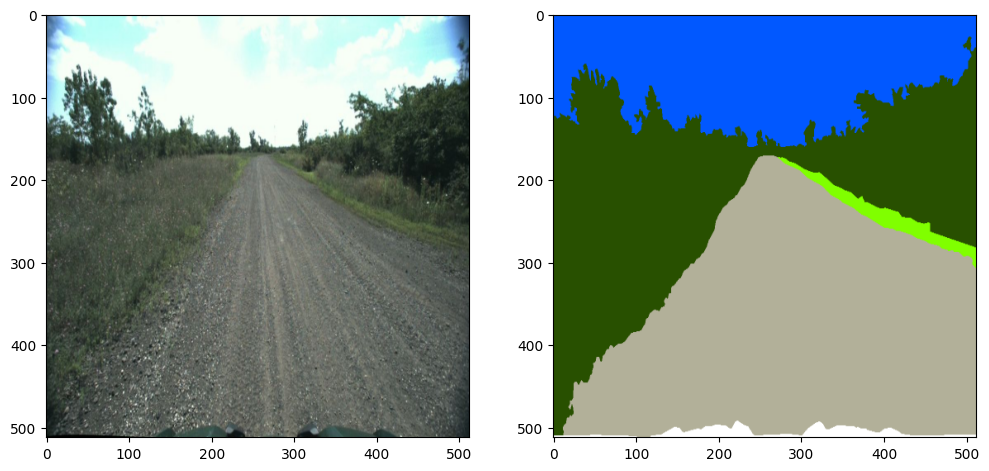

In [276]:
image_number=random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [277]:
mask_labels=pd.read_csv("E:/Offroad database/Rest of the files/class_dict_no_non_traversable_low_vegetation.csv")

In [278]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,background,255,255,255
2,high_vegetation,40,80,0
3,traversable_grass,128,255,0
4,smooth_trail,178,176,153
5,obstacle,255,0,0
6,sky,1,88,255
7,puddle,255,0,128


In [279]:
mask_labels.shape

(8, 4)

In [280]:
mask_labels.shape[0]

8

In [281]:
def rgb_to_labels(img, mask_labels):
    label_seg=np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img==list(mask_labels.iloc[i,[1,2,3]]), axis=-1)]=i
    label_seg=label_seg[:,:,0]
    return label_seg

In [282]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [283]:
labels=np.array(labels)
labels=np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [0 1 2 3 4 5 6 7]


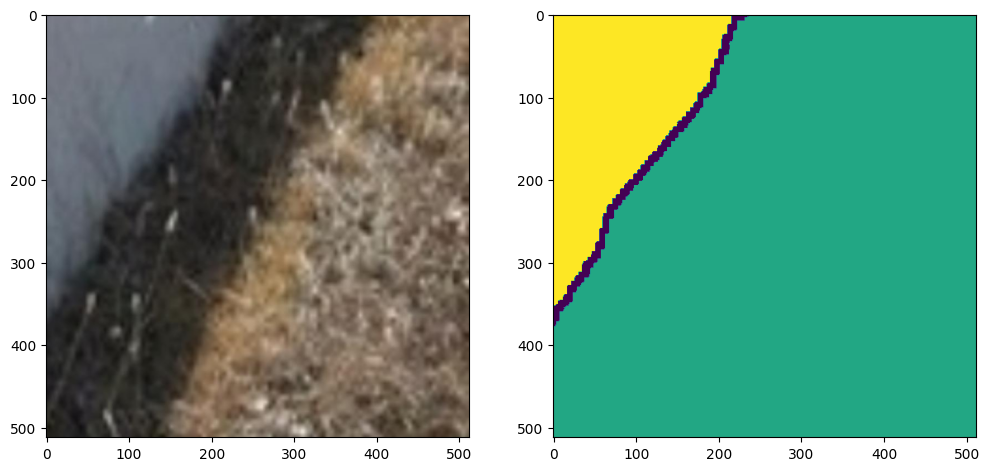

In [284]:
print("Unique labels in label dataset are: ", np.unique(labels))

image_number=random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [285]:
n_classes = len(np.unique(labels))
labels_cat=to_categorical(labels, num_classes=n_classes)

In [286]:
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 15:
        return 0.0001
    else:
        return 0.00001

In [287]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.2, random_state =42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.33)

In [289]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [290]:
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)
X_val_prepr=preprocess_input(X_val)

In [291]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [292]:
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [293]:
model_resnet_backbone.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_72 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [294]:
history = model_resnet_backbone.fit(X_train_prepr, y_train, batch_size=16, epochs=20, verbose=1, validation_data=(X_val_prepr, y_val), callbacks=[lr_scheduler])

Epoch 1/20
71/71 [==============================] - 305s 4s/step - loss: 1.0555 - accuracy: 0.6318 - val_loss: 267.8407 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 2/20
71/71 [==============================] - 295s 4s/step - loss: 0.7659 - accuracy: 0.7357 - val_loss: 1.7694 - val_accuracy: 0.4708 - lr: 0.0010
Epoch 3/20
71/71 [==============================] - 293s 4s/step - loss: 0.7361 - accuracy: 0.7440 - val_loss: 1.4193 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 4/20
71/71 [==============================] - 290s 4s/step - loss: 0.6352 - accuracy: 0.7834 - val_loss: 0.6774 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 5/20
71/71 [==============================] - 290s 4s/step - loss: 0.5862 - accuracy: 0.7990 - val_loss: 1.1587 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 6/20
71/71 [==============================] - 290s 4s/step - loss: 0.5859 - accuracy: 0.8010 - val_loss: 1.3902 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 7/20
71/71 [==============================] - 290s 4s/step - loss: 0

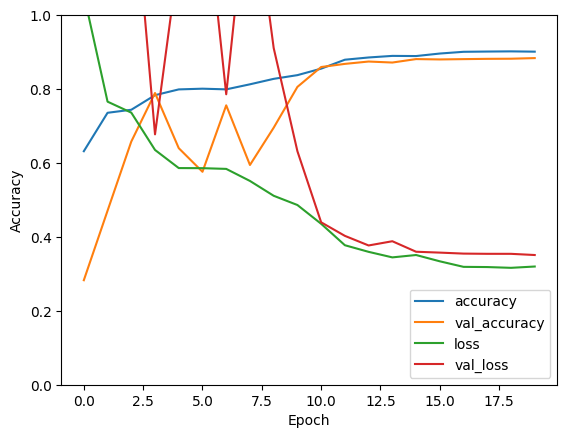

In [295]:
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0,1])
plt.legend(loc='lower right')
plt.savefig('segmented_yamaha_augmented_8_class_sample_512_3.png')

In [296]:
model_resnet_backbone.save("segmented_yamaha_augmented_8_class_sampled_data_512_3_resnet34.h5")

c:\Users\arahi\Anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [297]:
model = load_model('E:/Offroad database/yamaha_seg/segmented_yamaha_augmented_8_class_sampled_data_512_3_resnet34.h5')

In [298]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

6/6 [==============================] - 9s 1s/step


In [299]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#print(y_test)
#print(ground_truth)
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 169ms/step


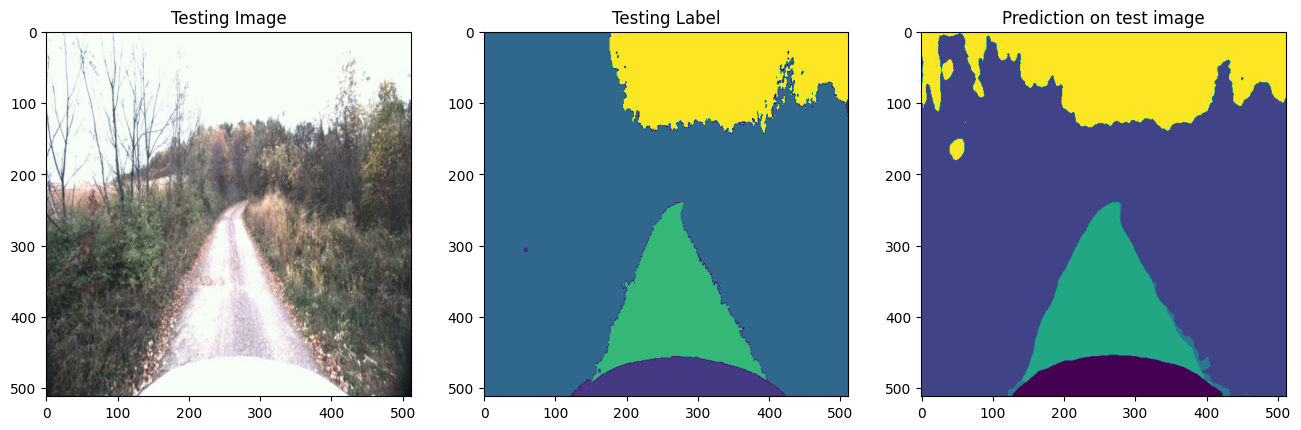

In [300]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [301]:
predicted_color_img = np.zeros((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)

colormap = {}
for index, row in mask_labels.iterrows():
    class_index = index  # Class index from the DataFrame
    rgb_color = [row.iloc[1], row.iloc[2], row.iloc[3]]  # RGB color values from the DataFrame
    colormap[class_index] = rgb_color

for class_index, rgb_color in colormap.items():
    predicted_color_img[predicted_img == class_index] = rgb_color

In [302]:
predicted_color_img

array([[[  1,  88, 255],
        [  1,  88, 255],
        [  1,  88, 255],
        ...,
        [  1,  88, 255],
        [  1,  88, 255],
        [ 40,  80,   0]],

       [[  1,  88, 255],
        [  1,  88, 255],
        [  1,  88, 255],
        ...,
        [  1,  88, 255],
        [  1,  88, 255],
        [  1,  88, 255]],

       [[  1,  88, 255],
        [  1,  88, 255],
        [  1,  88, 255],
        ...,
        [  1,  88, 255],
        [  1,  88, 255],
        [  1,  88, 255]],

       ...,

       [[ 40,  80,   0],
        [ 40,  80,   0],
        [ 40,  80,   0],
        ...,
        [ 40,  80,   0],
        [ 40,  80,   0],
        [ 40,  80,   0]],

       [[ 40,  80,   0],
        [ 40,  80,   0],
        [ 40,  80,   0],
        ...,
        [ 40,  80,   0],
        [ 40,  80,   0],
        [ 40,  80,   0]],

       [[ 40,  80,   0],
        [ 40,  80,   0],
        [ 40,  80,   0],
        ...,
        [ 40,  80,   0],
        [ 40,  80,   0],
        [ 40,  80,   0]]

In [1]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_color_img)
plt.show()

NameError: name 'plt' is not defined

In [304]:
validation_img=cv2.imread('E:/Offroad database/Rest of the files/Test Videos/barrier_on_grass.webp')
validation_img=cv2.cvtColor(validation_img, cv2.COLOR_BGR2RGB)
validation_img=cv2.resize(validation_img, (640,480))
validation_img=np.array(validation_img)

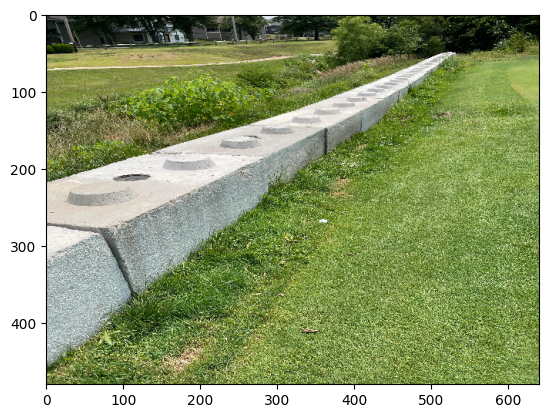

In [305]:
plt.imshow(validation_img)

In [306]:
validation_label=cv2.imread('E:/Offroad database/yamaha_seg/Data/Yamaha/Valid/labels/001050.png')
validation_label=cv2.cvtColor(validation_label, cv2.COLOR_BGR2RGB)
validation_label=cv2.resize(validation_label, (640,480))
validation_label=np.array(validation_label)

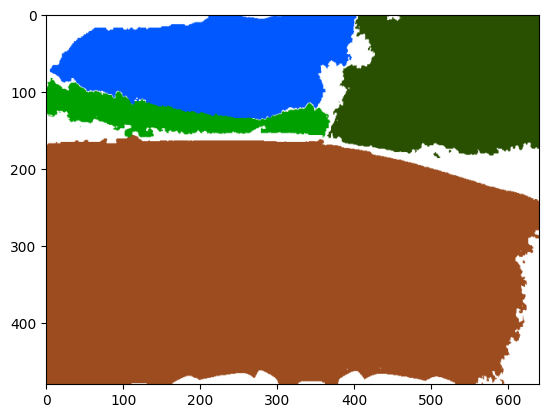

In [307]:
plt.imshow(validation_label)

In [308]:
validation_img=np.expand_dims(validation_img, 0)
prediction=model.predict(validation_img)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


1/1 [==============================] - 3s 3s/step


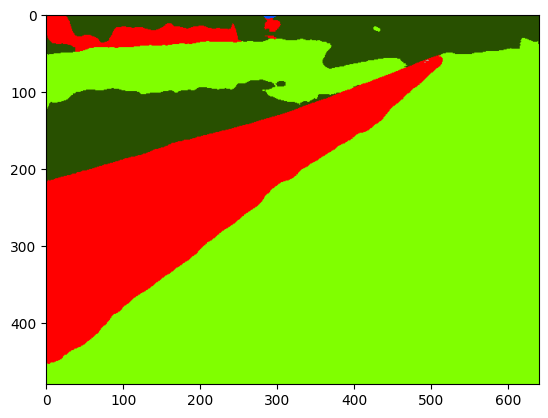

In [309]:
predicted_color_img = np.zeros((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)

colormap = {}
for index, row in mask_labels.iterrows():
    class_index = index  # Class index from the DataFrame
    rgb_color = [row.iloc[1], row.iloc[2], row.iloc[3]]  # RGB color values from the DataFrame
    colormap[class_index] = rgb_color

for class_index, rgb_color in colormap.items():
    predicted_color_img[predicted_img == class_index] = rgb_color
plt.imshow(predicted_color_img)

In [310]:
print(y_pred_argmax.flatten())

[2 2 2 ... 4 4 3]


In [311]:
from sklearn.metrics import confusion_matrix

def calculate_miou(y_true, y_pred, num_classes, exclude_classes):
    # Flatten the 2D arrays to 1D arrays
    y_true_flat = y_true.flatten()

    y_pred_int = np.round(y_pred).astype(int)
    y_pred_flat = y_pred_int.flatten()

    # Compute the confusion matrix
    labels_to_include = [i for i in range(num_classes) if i not in exclude_classes]
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels_to_include)

    #Calculate the Intersection over Union (IoU) for each class
    class_iou = np.diag(cm) / (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm) + 1e-15)

    # Calculate the mean IoU (mIoU)
    miou = np.nanmean(class_iou)

    return cm, miou, class_iou

In [312]:
exclude_classes=[0,1,7]
cm, miou, class_iou = calculate_miou(y_test_argmax, y_pred_argmax, 8, exclude_classes)

print("mIoU:", miou)
print("Class IoU:", class_iou)

mIoU: 0.7940766316265334
Class IoU: [0.8222216  0.61160081 0.85465238 0.80990012 0.87200825]


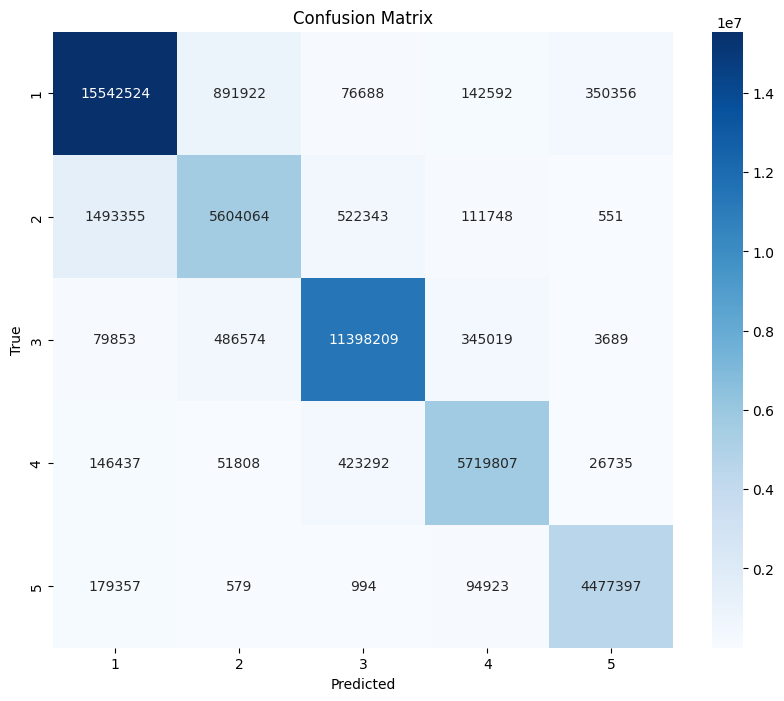

In [313]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [314]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# Assuming you have ground truth labels (y_true) and predicted labels (y_pred)
# Each label is an integer representing the class for each pixel

# Generate random ground truth and predicted labels for demonstration
# np.random.seed(42)
# y_true = np.random.randint(0, 9, size=(100, 100))  # Replace with your actual ground truth
# y_pred = np.random.randint(0, 9, size=(100, 100))  # Replace with your actual predicted labels

# Flatten the 2D arrays into 1D arrays
y_true_flat = y_test_argmax.flatten()
y_pred_flat = y_pred_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f'Accuracy: {accuracy:.4f}')

# Calculate recall for each class
recall_per_class = recall_score(y_true_flat, y_pred_flat, average=None)
print(f'Recall per class: {recall_per_class}')

# Calculate macro-average recall
macro_recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print(f'Macro-average Recall: {macro_recall:.4f}')

# Calculate micro-average recall
micro_recall = recall_score(y_true_flat, y_pred_flat, average='micro')
print(f'Micro-average Recall: {micro_recall:.4f}')

# Calculate F1-score for each class
f1_per_class = f1_score(y_true_flat, y_pred_flat, average=None)
print(f'F1-score per class: {f1_per_class}')

# Calculate macro-average F1-score
macro_f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print(f'Macro-average F1-score: {macro_f1:.4f}')

# Calculate micro-average F1-score
micro_f1 = f1_score(y_true_flat, y_pred_flat, average='micro')
print(f'Micro-average F1-score: {micro_f1:.4f}')

Accuracy: 0.8733
Recall per class: [4.41723881e-04 7.20558317e-01 9.14001165e-01 7.24241765e-01
 9.24106528e-01 8.98104418e-01 9.41824710e-01 0.00000000e+00]
Macro-average Recall: 0.6404
Micro-average Recall: 0.8733
F1-score per class: [8.80952617e-04 8.02143202e-01 8.96101120e-01 7.53111825e-01
 9.12217922e-01 8.85938947e-01 9.24385584e-01 0.00000000e+00]
Macro-average F1-score: 0.6468
Micro-average F1-score: 0.8733


In [315]:
mask_dataset.shape[0]

1414